In [ ]:
# 1. Initialize Client and Load Data

import pandas as pd
import numpy as np
from agentds import BenchmarkClient

# 🔑 REPLACE WITH YOUR CREDENTIALS
client = BenchmarkClient(
    api_key="your-api-key-here",        # Get from your team dashboard
    team_name="your-team-name-here"     # Your exact team name
)

print("📂 Loading Manufacturing Challenge 2 data...")

# Load sensor readings data
train_batches = pd.read_csv("../datasets/batches_train.csv")
test_batches = pd.read_csv("../datasets/batches_test.csv")

print(f"✅ Data loaded")
print(train_batches.shape)
print(test_batches.shape)

📂 Loading Manufacturing Challenge 2 data...
✅ Data loaded
(1000, 7)
(1000, 6)


## Vision Modeling

In [235]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
import pandas as pd
from tqdm import tqdm

In [236]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),        # Resize to model input
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],      # Imagenet mean
        std=[0.229, 0.224, 0.225]        # Imagenet std
    ),
])

In [237]:
# Use ResNet50 for simplicity; CLIP or ViT also possible
# model = models.resnet50(pretrained=True)
# model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(*list(model.children())[:-1])  # remove last layer
model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
  

In [238]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
  

In [ ]:
def extract_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = model(image).squeeze().cpu().numpy()
        return embedding
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

image_dir = "../datasets/inspection_images"
embeddings = {}

# Loop over all images
for filename in tqdm(os.listdir(image_dir)):
    if filename.endswith(".png"):
        unit_id = filename.replace("IMG_", "").replace(".png", "")
        img_path = os.path.join(image_dir, filename)
        emb = extract_embedding(img_path)
        if emb is not None:
            embeddings[unit_id] = emb


In [188]:
# Convert to DataFrame
emb_df = pd.DataFrame.from_dict(embeddings, orient='index')
emb_df.reset_index(inplace=True)
emb_df.rename(columns={'index': 'unit_id'}, inplace=True)


In [262]:
train_batches = train_batches.merge(emb_df, on="unit_id", how="left")
test_batches = test_batches.merge(emb_df, on="unit_id", how="left")

## End of Vision Modeling

In [263]:
target = "ReworkCostUSD"
features = [c for c in train_batches.columns if c not in ["unit_id", "machine_id", target, "speed_rpm", "feed_mm_rev"]]

In [264]:
machine_mean = train_batches.groupby("machine_id")[target].mean().rename("machine_mean_rework")
train_batches = train_batches.merge(machine_mean, on="machine_id", how="left")
test_batches  = test_batches.merge(machine_mean.reset_index(), on="machine_id", how="left")
# Fill missing machine means in test with global mean
global_mean = train_batches[target].mean()
test_batches["machine_mean_rework"] = test_batches["machine_mean_rework"].fillna(global_mean)

features += ["machine_mean_rework"]

In [265]:
X_train = train_batches[features]
y_train = train_batches[target].values
X_test = test_batches[features]

In [266]:
y_log = np.log1p(y_train)

In [247]:
def gini(actual, pred):
    # compute gini
    assert len(actual) == len(pred)
    n = len(actual)
    arr = np.array(np.c_[actual, pred, np.arange(n)], dtype=np.float64)
    # sort by pred desc, then by index
    arr = arr[np.lexsort((arr[:,2], -arr[:,1]))]
    total_losses = arr[:,0].sum()
    gini_sum = arr[:,0].cumsum().sum() / total_losses
    gini_sum -= (n + 1) / 2.0
    return gini_sum / n

def normalized_gini(actual, pred):
    return gini(actual, pred) / gini(actual, actual)


In [248]:
gini_scores = []

In [227]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import GroupKFold
from itertools import product
from tqdm import tqdm
import random

# --- GroupKFold setup ---
groups = train_batches["machine_id"].values
gkf = GroupKFold(n_splits=5)

# --- Parameter grid ---

param_grid = {
    "num_leaves": [8, 16, 31],        # small leaves → shallow trees
    "max_depth": [3, 4, 5],           # shallow trees to avoid overfitting
    "min_data_in_leaf": [5, 10, 20],  # small number since dataset is tiny
    "feature_fraction": [0.2, 0.4, 0.6],  # strong column subsampling
    "bagging_fraction": [0.7, 0.8, 0.9],  # row subsampling
    "bagging_freq": [1],               # enable bagging every iteration
    "lambda_l1": [0.1, 0.5, 1.0],     # encourage sparsity
    "lambda_l2": [0.1, 0.5, 1.0],     # smoothness
    "learning_rate": [0.01, 0.03],    # smaller LR to stabilize
}

param_combos = list(product(*param_grid.values()))

best_score = -1
best_params = None

param_combos = random.sample(param_combos, 30)

# --- Start tuning ---
for combo in tqdm(param_combos, desc="Tuning LGBM"):
    params = dict(zip(param_grid.keys(), combo))
    params.update({
        "objective": "rmse",
        "verbose": -1,
        "seed": 42,
        "n_estimators": 3000
    })

    fold_scores = []

    for tr_idx, val_idx in gkf.split(X_train, y_log, groups):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_log[tr_idx], y_log[val_idx]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse"
        )

        y_pred = model.predict(X_val)
        score = normalized_gini(np.expm1(y_val), np.expm1(y_pred))
        fold_scores.append(score)

    mean_score = np.mean(fold_scores)

    print(f"{params} => Gini: {mean_score:.5f}")
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print("\n✅ Best params:", best_params)
print("✅ Best normalized Gini:", best_score)


Tuning LGBM:   3%|▎         | 1/30 [00:45<21:46, 45.05s/it]

{'num_leaves': 31, 'max_depth': 5, 'min_data_in_leaf': 20, 'feature_fraction': 0.4, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 1.0, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.80006


Tuning LGBM:   7%|▋         | 2/30 [01:18<17:58, 38.51s/it]

{'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 10, 'feature_fraction': 0.4, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 0.5, 'learning_rate': 0.01, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.79835


Tuning LGBM:  10%|█         | 3/30 [01:48<15:32, 34.54s/it]

{'num_leaves': 16, 'max_depth': 3, 'min_data_in_leaf': 10, 'feature_fraction': 0.2, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'lambda_l1': 1.0, 'lambda_l2': 0.1, 'learning_rate': 0.01, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.79938


Tuning LGBM:  13%|█▎        | 4/30 [02:24<15:12, 35.08s/it]

{'num_leaves': 8, 'max_depth': 5, 'min_data_in_leaf': 20, 'feature_fraction': 0.4, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 0.5, 'lambda_l2': 0.5, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.79610


Tuning LGBM:  17%|█▋        | 5/30 [02:59<14:31, 34.85s/it]

{'num_leaves': 8, 'max_depth': 5, 'min_data_in_leaf': 20, 'feature_fraction': 0.6, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'lambda_l1': 1.0, 'lambda_l2': 0.1, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.80042


Tuning LGBM:  20%|██        | 6/30 [03:35<14:06, 35.26s/it]

{'num_leaves': 16, 'max_depth': 5, 'min_data_in_leaf': 20, 'feature_fraction': 0.4, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 0.5, 'lambda_l2': 0.1, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.80206


Tuning LGBM:  23%|██▎       | 7/30 [04:07<13:09, 34.35s/it]

{'num_leaves': 31, 'max_depth': 3, 'min_data_in_leaf': 20, 'feature_fraction': 0.4, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'lambda_l1': 0.5, 'lambda_l2': 0.5, 'learning_rate': 0.01, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.79791


Tuning LGBM:  27%|██▋       | 8/30 [04:34<11:42, 31.93s/it]

{'num_leaves': 16, 'max_depth': 3, 'min_data_in_leaf': 5, 'feature_fraction': 0.2, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 1.0, 'lambda_l2': 0.1, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.80324


Tuning LGBM:  30%|███       | 9/30 [05:03<10:52, 31.09s/it]

{'num_leaves': 31, 'max_depth': 3, 'min_data_in_leaf': 10, 'feature_fraction': 0.2, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 0.1, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.79866


Tuning LGBM:  33%|███▎      | 10/30 [05:33<10:15, 30.76s/it]

{'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 1.0, 'lambda_l2': 0.5, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.80399


Tuning LGBM:  37%|███▋      | 11/30 [06:08<10:07, 32.00s/it]

{'num_leaves': 16, 'max_depth': 5, 'min_data_in_leaf': 10, 'feature_fraction': 0.4, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'lambda_l1': 1.0, 'lambda_l2': 1.0, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.80106


Tuning LGBM:  40%|████      | 12/30 [06:51<10:35, 35.29s/it]

{'num_leaves': 31, 'max_depth': 5, 'min_data_in_leaf': 10, 'feature_fraction': 0.4, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 0.1, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.80194


Tuning LGBM:  43%|████▎     | 13/30 [07:22<09:38, 34.02s/it]

{'num_leaves': 31, 'max_depth': 3, 'min_data_in_leaf': 20, 'feature_fraction': 0.4, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 0.5, 'lambda_l2': 1.0, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.80305


Tuning LGBM:  47%|████▋     | 14/30 [07:55<08:58, 33.65s/it]

{'num_leaves': 16, 'max_depth': 4, 'min_data_in_leaf': 20, 'feature_fraction': 0.6, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'lambda_l1': 1.0, 'lambda_l2': 0.5, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.80097


Tuning LGBM:  50%|█████     | 15/30 [08:24<08:03, 32.25s/it]

{'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 10, 'feature_fraction': 0.2, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 0.5, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.79969


Tuning LGBM:  53%|█████▎    | 16/30 [09:00<07:47, 33.39s/it]

{'num_leaves': 16, 'max_depth': 4, 'min_data_in_leaf': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 0.5, 'lambda_l2': 0.1, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.80319


Tuning LGBM:  57%|█████▋    | 17/30 [09:44<07:56, 36.68s/it]

{'num_leaves': 16, 'max_depth': 4, 'min_data_in_leaf': 10, 'feature_fraction': 0.6, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 0.1, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.79657


Tuning LGBM:  60%|██████    | 18/30 [10:24<07:33, 37.79s/it]

{'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 10, 'feature_fraction': 0.6, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 0.5, 'lambda_l2': 0.1, 'learning_rate': 0.01, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.79936


Tuning LGBM:  63%|██████▎   | 19/30 [10:55<06:31, 35.63s/it]

{'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'feature_fraction': 0.2, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 0.5, 'lambda_l2': 0.1, 'learning_rate': 0.01, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.80027


Tuning LGBM:  67%|██████▋   | 20/30 [11:31<05:56, 35.63s/it]

{'num_leaves': 31, 'max_depth': 5, 'min_data_in_leaf': 10, 'feature_fraction': 0.4, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'lambda_l1': 0.5, 'lambda_l2': 0.1, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.79680


Tuning LGBM:  70%|███████   | 21/30 [12:13<05:39, 37.72s/it]

{'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'feature_fraction': 0.6, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'lambda_l1': 0.5, 'lambda_l2': 0.5, 'learning_rate': 0.01, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.79978


Tuning LGBM:  73%|███████▎  | 22/30 [12:43<04:42, 35.35s/it]

{'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'feature_fraction': 0.2, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 0.1, 'learning_rate': 0.01, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.80113


Tuning LGBM:  77%|███████▋  | 23/30 [13:41<04:54, 42.05s/it]

{'num_leaves': 31, 'max_depth': 4, 'min_data_in_leaf': 20, 'feature_fraction': 0.6, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'lambda_l1': 0.5, 'lambda_l2': 1.0, 'learning_rate': 0.01, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.80013


Tuning LGBM:  80%|████████  | 24/30 [14:14<03:56, 39.43s/it]

{'num_leaves': 31, 'max_depth': 5, 'min_data_in_leaf': 20, 'feature_fraction': 0.2, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'lambda_l1': 0.5, 'lambda_l2': 1.0, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.79940


Tuning LGBM:  83%|████████▎ | 25/30 [14:59<03:25, 41.03s/it]

{'num_leaves': 8, 'max_depth': 5, 'min_data_in_leaf': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 1.0, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.79742


Tuning LGBM:  87%|████████▋ | 26/30 [15:31<02:33, 38.35s/it]

{'num_leaves': 16, 'max_depth': 3, 'min_data_in_leaf': 20, 'feature_fraction': 0.4, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 1.0, 'learning_rate': 0.01, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.80033


Tuning LGBM:  90%|█████████ | 27/30 [16:35<02:18, 46.18s/it]

{'num_leaves': 31, 'max_depth': 4, 'min_data_in_leaf': 5, 'feature_fraction': 0.6, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'lambda_l1': 1.0, 'lambda_l2': 1.0, 'learning_rate': 0.01, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.80178


Tuning LGBM:  93%|█████████▎| 28/30 [17:24<01:33, 46.90s/it]

{'num_leaves': 16, 'max_depth': 5, 'min_data_in_leaf': 20, 'feature_fraction': 0.2, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 0.1, 'learning_rate': 0.01, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.80096


Tuning LGBM:  97%|█████████▋| 29/30 [18:46<00:57, 57.44s/it]

{'num_leaves': 31, 'max_depth': 5, 'min_data_in_leaf': 10, 'feature_fraction': 0.4, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 0.5, 'learning_rate': 0.01, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.79964


Tuning LGBM: 100%|██████████| 30/30 [19:19<00:00, 38.64s/it]

{'num_leaves': 31, 'max_depth': 3, 'min_data_in_leaf': 5, 'feature_fraction': 0.6, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'lambda_l1': 1.0, 'lambda_l2': 0.5, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => Gini: 0.79773

✅ Best params: {'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 1.0, 'lambda_l2': 0.5, 'learning_rate': 0.03, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'n_estimators': 3000}
✅ Best normalized Gini: 0.80399303197763


In [295]:
final_model = lgb.LGBMRegressor(
    n_estimators=3000,
    num_leaves=8,
    max_depth= 3,
    min_data_in_leaf=5,
    feature_fraction=0.2,
    bagging_fraction=0.8,
    bagging_freq=1,
    lambda_l1=1,
    lambda_l2=0.5,
    learning_rate=0.03,
    verbose=-1,
    random_state=42,
    #boosting_type="goss"
)

final_model.fit(X_train, y_log)

,boosting_type,'gbdt'
,num_leaves,8
,max_depth,3
,learning_rate,0.03
,n_estimators,3000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


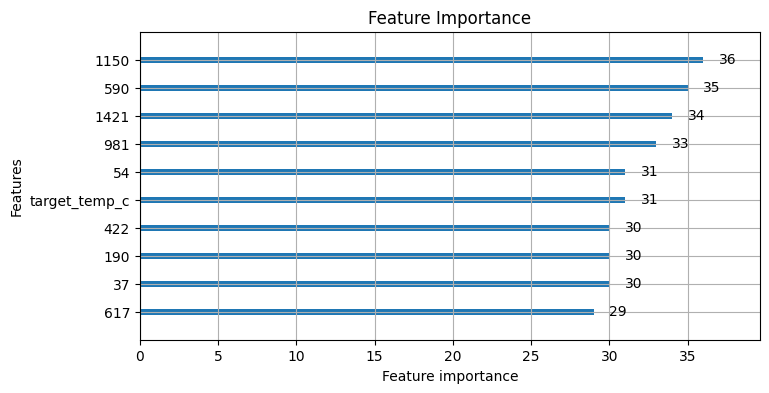

In [250]:
import matplotlib.pyplot as plt
lgb.plot_importance(final_model, figsize=(8, 4), max_num_features=10)
plt.title("Feature Importance")
plt.show()

In [296]:
predictions = final_model.predict(X_test)

In [297]:
submission_df = pd.DataFrame({
    'unit_id': test_batches['unit_id'],
    'ReworkCostUSD': predictions
})

# Save predictions
submission_df.to_csv("manufacturing_challenge2_predictions.csv", index=False)
print(f"✅ Predictions saved: {submission_df.shape[0]} predictions")
print(f"   Preview: {submission_df.head(3)}")
print(f"   Cost range: ${predictions.min():.2f} to ${predictions.max():.2f}")

✅ Predictions saved: 1000 predictions
   Preview:   unit_id  ReworkCostUSD
0  U00002       4.039661
1  U00005       3.134589
2  U00006       2.672609
   Cost range: $1.57 to $5.40


In [298]:
# 3. Submit Predictions

# Submit predictions to the competition
print("🚀 Submitting predictions...")

try:
    result = client.submit_prediction("Manufacturing", 2, "manufacturing_challenge2_predictions.csv")
    
    if result['success']:
        print("✅ Submission successful!")
        print(f"   📊 Score: {result['score']:.4f}")
        print(f"   📏 Metric: {result['metric_name']}")
        print(f"   ✔️  Validation: {'Passed' if result['validation_passed'] else 'Failed'}")
    else:
        print("❌ Submission failed!")
        print(f"   Error details: {result.get('details', {}).get('validation_errors', 'Unknown error')}")
        
except Exception as e:
    print(f"💥 Submission error: {e}")
    print("🔧 Check your API key and team name are correct!")

print("\n🎯 Next steps:")
print("   1. Try incorporating relevant information outside this table!")
print("   2. Move on to Manufacturing Challenge 3!")


🚀 Submitting predictions...
✅ Prediction submitted successfully!
📊 Score: 0.8103 (Normalized Gini)
✅ Validation passed
✅ Submission successful!
   📊 Score: 0.8103
   📏 Metric: Normalized Gini
   ✔️  Validation: Passed

🎯 Next steps:
   1. Try incorporating relevant information outside this table!
   2. Move on to Manufacturing Challenge 3!
